<h1>Описание проекта</h1>

<p>Я - аналитик в стартапе, который продаёт продукты питания. Мне следует разобраться, как ведут себя пользователи вашего мобильного приложения.</p>

<b>Цель:</b>

Изучить воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

<b>Описание данных:</b>

<b>EventName</b> — название события;

<b>DeviceIDHash</b> — уникальный идентификатор пользователя;

<b>EventTimestamp</b> — время события;

<b>ExpId</b> — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

<h2>Шаг 1. Откройте файл с данными и изучите общую информацию</h2>

In [406]:
import pandas as pd
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
import datetime

In [407]:
data = pd.read_csv('/datasets/logs_exp.csv', sep = "\t")

In [408]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<h2>Шаг 2. Подготовьте данные</h2>

Изменим названия столбцов в привычные для использования

In [409]:
data.columns = ['event_name', 'user_id', 'datetime', 'exp_id']

Теперь оценим сами данные

In [410]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   datetime    244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Необходимо конвертировать формат Timestamp в datetime

In [411]:
data['datetime'] = pd.to_datetime(data['datetime'],unit='s')

Добавим отельный столбец только с датами:

In [412]:
data['date'] = data['datetime'].dt.date

In [413]:
data.head()

,event_name,user_id,datetime,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   datetime    244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   date        244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


Теперь посчитаем и удалим дубликаты (по необходимости)

In [415]:
print(f'Сумма дубликатов: {data.duplicated().sum()}')

Сумма дубликатов: 413


In [416]:
print(f'Дубликаты занимают: {round(data.duplicated().sum()/len(data)*100,4)} % от всего датасета')

Дубликаты занимают: 0.1692 % от всего датасета


In [417]:
data = data.drop_duplicates().reset_index(drop=True)

In [418]:
print(f'Сумма дубликатов: {data.duplicated().sum()}')

Сумма дубликатов: 0


Теперь когда, мы подготовили наши данные, мы можем приступать к изучению данных

Проверим, есть ли пересечения среди пользователей в обеих группах

In [419]:
user_246 = data.query('exp_id == 246')['user_id']

In [420]:
user_247 = data.query('exp_id == 247')['user_id']

In [421]:
user_248 = data.query('exp_id == 248')['user_id']

In [422]:
duplicates_user_1 = (list(set(user_246).intersection(set(user_247))))

In [423]:
duplicates_user_1

[]

Массив пустой, а это значит, что пересечения среди пользователей в группах 246 и 247 нет, проверим пересечение среди остальных групп.

In [424]:
duplicates_user_2 = (list(set(user_246).intersection(set(user_248))))

In [425]:
duplicates_user_2

[]

In [426]:
duplicates_user_3 = (list(set(user_247).intersection(set(user_248))))

In [427]:
duplicates_user_3

[]

Пересечений среди пользоватей в группах не оказлось, это значит, что A/A/B тестирование было запущенно корректно.

<h2>Шаг 3. Изучите и проверьте данные</h2>

<b>Сколько всего событий в логе?</b>

In [428]:
print('Cобытий в логе:')
len(data['event_name'])

Cобытий в логе:


243713

<b>Сколько всего пользователей в логе?</b>

In [429]:
print('Пользователей в логе:')
len(data['user_id'].unique())

Пользователей в логе:


7551

<b>Сколько в среднем событий приходится на пользователя?</b>

In [430]:
event_grouped = data.groupby('user_id').agg({'event_name': ['count']})

In [431]:
print(f'В среднем событий на пользователя приходится:')
int(event_grouped['event_name'].mean())


В среднем событий на пользователя приходится:


32

In [432]:
users_group = data.groupby('user_id').agg({'datetime':'nunique'})

In [433]:
users_group.columns = ['count_event']

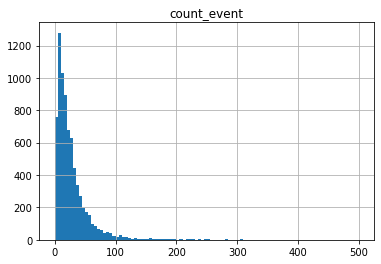

In [434]:
users_group.hist(bins=100, range=(0,500));

In [435]:
users_group.describe()

,count_event
count,7551.000000
mean,29.208979
std,57.050040
min,1.000000
25%,9.000000
50%,18.000000
75%,34.000000
max,2242.000000


In [436]:
users_group.sort_values(by = 'count_event', ascending = False).head(10)

,count_event
user_id,
6304868067479728361,2242
197027893265565660,1730
4623191541214045580,1592
6932517045703054087,1295
1754140665440434215,981
3337471580007169353,878
7738058666231999878,746
4713748699910253089,702
1055544042902443290,668


<b>Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?</b>

In [437]:
print('Минимальная дата:')
data['datetime'].min()

Минимальная дата:


Timestamp('2019-07-25 04:43:36')

In [438]:
data['datetime'].max()

Timestamp('2019-08-07 21:15:17')

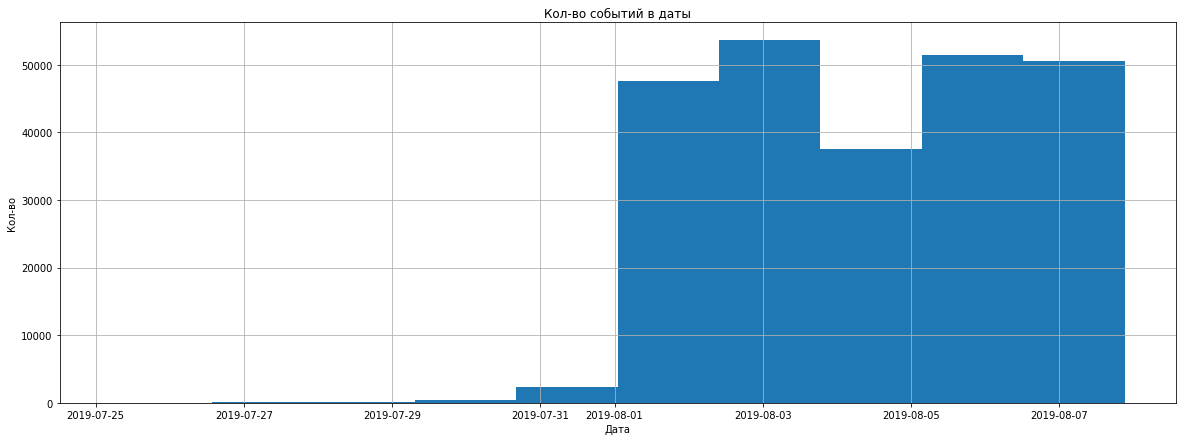

In [439]:
plt.figure(figsize=(20,7))
data['datetime'].hist( bins = 10)
plt.title('Кол-во событий в даты')
plt.ylabel("Кол-во")
plt.xlabel("Дата")
plt.show()

На гистограмме можно заметить, что полные данные начинаются с 1 августа и идут до 8 августа. Это значит, что мы будем использовать для рассмотрения именно этот период. Более ранные данные мы обрежем.

In [440]:
print('Мы располагаем данными на следующий период:')
data['datetime'].max() - data['datetime'].min()

Мы располагаем данными на следующий период:


Timedelta('13 days 16:31:41')

Отрежим ненужные старые данные

In [441]:
data_new = data.query('date > datetime.date(2019, 7, 31)')

Проверим, получилось ли отсечь данные

In [442]:
data_new.sort_values(by='date', ascending = True).head()

,event_name,user_id,datetime,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
26929,CartScreenAppear,4933689529142781210,2019-08-01 15:42:14,246,2019-08-01
26928,MainScreenAppear,5375697691143223385,2019-08-01 15:42:13,247,2019-08-01
26927,MainScreenAppear,5122452238037348165,2019-08-01 15:42:12,248,2019-08-01
26926,MainScreenAppear,370831337408248129,2019-08-01 15:42:10,247,2019-08-01


<b>Много ли событий и пользователей вы потеряли, отбросив старые данные?</b>

In [443]:
print('После того, как мы отбросили старые данные, мы потеряли следующее кол-во событий:')
data['event_name'].count() - data_new['event_name'].count()

После того, как мы отбросили старые данные, мы потеряли следующее кол-во событий:


2826

In [444]:
lose_event = round((data['event_name'].count() - data_new['event_name'].count())/data['event_name'].count()*100,2)

In [445]:
print(f'После того, как мы отбросили старые данные, мы потеряли {lose_event} % событий')

После того, как мы отбросили старые данные, мы потеряли 1.16 % событий


In [446]:
print('После того, как мы отбросили старые данные, мы потеряли следующее кол-во уникальных пользователей:')
len(data['user_id'].unique()) - len(data_new['user_id'].unique())

После того, как мы отбросили старые данные, мы потеряли следующее кол-во уникальных пользователей:


17

In [447]:
lose_user = round((len(data['user_id'].unique()) - len(data_new['user_id'].unique()))/data['event_name'].count()*100,2)

In [448]:
print(f'После того, как мы отбросили старые данные, мы потеряли {lose_user} % уникальных пользователей')

После того, как мы отбросили старые данные, мы потеряли 0.01 % уникальных пользователей


<b>Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.</b>

In [449]:
data.groupby('exp_id')['user_id'].nunique()

exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

In [450]:
data_new.groupby('exp_id')['user_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Пользователи остались, мы потеряли лишь 5 пользователей в 246 группе, 7 пользователей в 247 и 5 пользователей в 248 группе

<h2>Шаг 4. Изучите воронку событий</h2>

<b>Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.</b>

In [451]:
event_group = data_new.groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by ='user_id', ascending= False)

In [452]:
event_group

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Наиболее частовстреаемое событие 'MainScreenAppear', а то есть переход на главный экран. Самое редкое событие это "Tutorial" - обучение.

<b>Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.</b>

In [453]:
event_group['ratio'] = round(event_group['user_id']/data_new['user_id'].nunique(), 2)*100

In [454]:
event_group

,user_id,ratio
event_name,,
MainScreenAppear,7419,98.0
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,50.0
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.0


98 % пользователей переходили на главную страницу и лишь только 11 % пользователей, от всех кто когда либо совершал действие, посмотрели обучение

<b>Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.</b>

События могут происходить в следующем порядке:
<ol>
    <li>MainScreenAppear - Главная страница приложения</li>
    <li>Tutorial - Обучение </li>
    <li>OffersScreenAppear - Страница с товарами</li>
    <li>CartScreenAppear - Страница корзины</li>
    <li>PaymentScreenSuccessful - Страница оплаты</li>
</ol>

Страница с обучением не выстраивается в последовательную цепчку покупки товара, поэтому мы не будем ее учитывать в общей воронке.

<b>По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.</b>

Создадим столбец с "cr_screen" в котором поделим элементы по условию:

In [455]:
event_group['cr_screen'] = (round(event_group['user_id'].shift(-1) / event_group['user_id'],2)*100).shift(1)

Удалим строчку 'Tutorial' и посмотрим на % изменения в воронке

In [456]:
event_group = event_group.drop(event_group.index[[4]])

In [457]:
event_group

,user_id,ratio,cr_screen
event_name,,,
MainScreenAppear,7419,98.0,NaN
OffersScreenAppear,4593,61.0,62.0
CartScreenAppear,3734,50.0,81.0
PaymentScreenSuccessful,3539,47.0,95.0


В итоге мы можем сделать вывод, о том, что конверсия переходов с главной страницы на страницу с товарами составляет 62%,

конверсия переходов со страницы с товарами на страницу корзины составляет 81%.

Конверсия переходов с корзины в оплату состаяет 95%

In [458]:
from plotly import graph_objects as go

In [459]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Пользователи',
    y = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
    x = event_group['user_id'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Конверсия страницы',
    orientation = "h",
    y = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful'],
    x = event_group['cr_screen'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show()

<b>На каком шаге теряете больше всего пользователей?</b>

Больше всего пользоватеей отпадают после перехода с главной страницы на страницу товаров. 62%. Далее, идут пользователи которые добавляют товар в корзину. 81%.Наименьший % пользователей теряется при переходе с корзины в страницу оплаты. 95%

<b>Какая доля пользователей доходит от первого события до оплаты?</b>

На воронке выше мы можем увидеть, что % пользователей, который доходит с главной страницы до страницы оплаты - составляет 48%.

<h2>Шаг 5. Изучите результаты эксперимента</h2>

<b>Сколько пользователей в каждой экспериментальной группе?</b>

In [460]:
user_group_exp = data_new.groupby('exp_id')['user_id'].nunique()

In [461]:
user_group_exp

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

В группе <b>248</b> - 2484 пользователя,

В группе <b>246</b> - 2513 пользователя,

В группе <b>247</b> - 2537 пользователя.

<b>Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.</b>

Для этого мы найдем кол-во уникальных пользователей из 246 и 247 группы

In [462]:
exp_246 = data_new.query('exp_id == 246')['user_id'].nunique()

In [463]:
exp_247 = data_new.query('exp_id == 247')['user_id'].nunique()

In [464]:
exp_248 = data_new.query('exp_id == 248')['user_id'].nunique()

Сформулируем нулевую и альтернативную гипотезу:

<b>H0:</b> Статистически значимой разницы между выборками из групп 246 и 247 нет

<b>H1:</b> Статистически значимая разница между между выборками из групп 246 и 247 есть

За уровень значимости возьмем alpha в 1%. Т.Е мы  на 99% уверены в том, что различия действительно достоверны.

In [465]:
alpha = .01

successes = np.array([exp_246, exp_247])
trials = np.array([exp_246 + exp_247, exp_246 + exp_247])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

In [466]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

In [467]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    )

p-значение:  0.5617972322745155
Не получилось отвергнуть нулевую гипотезу


Это означает, что выборки из групп нам подходят и мы можем их использовать для дальнейшего эксперимента

<b>Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?</b>

Сгрупируем пользователей по событию, отсортируем и построим диаграмму. 

In [468]:
event_group = data_new.groupby('event_name').agg({'user_id': 'nunique'}).reset_index()

In [469]:
event_group.columns = ['event_name', 'user_count']

In [470]:
event_group = event_group.sort_values(by = 'user_count', ascending = False)

In [471]:
event_group

,event_name,user_count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


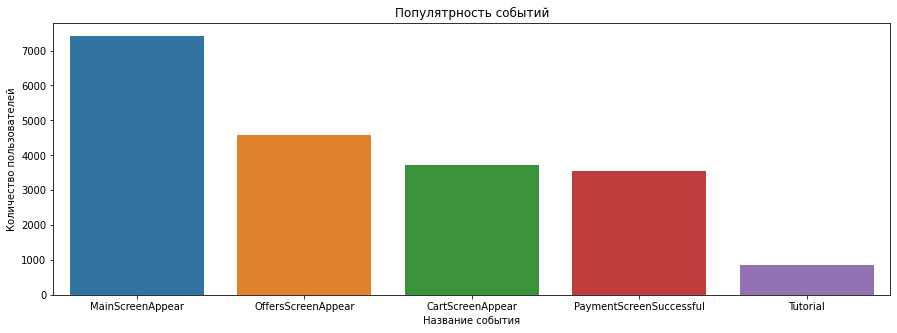

In [472]:
plt.figure(figsize=(15,5))
sns.barplot(data=event_group, x="event_name", y="user_count")
plt.title('Популятрность событий')
plt.xlabel('Название события')
plt.ylabel('Количество пользователей');

Самое популярное событие это 'MainScreenAppear' или просмотр главной страницы.

Теперь посмотрим на число таких пользователей, совершившие данное событие в каждой группе:

In [473]:
event_group_exp = data_new.pivot_table(index = 'event_name', columns = 'exp_id', values ='user_id', aggfunc = 'nunique' ).reset_index()

In [474]:
event_group_exp = event_group_exp.sort_values(by = [246, 247], ascending = False)

In [475]:
event_group_exp

exp_id,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


Теперь посчитаем долю пользователей, совершивших это событие.

In [476]:
event_group_exp['246_247'] = event_group_exp[246]+event_group_exp[247]
event_group_exp['ratio_246'] = round(event_group_exp[246]/user_group_exp[246],2)*100
event_group_exp['ratio_247'] = round(event_group_exp[247]/user_group_exp[247],2)*100


In [477]:
event_group_exp.head()

exp_id,event_name,246,247,248,246_247,ratio_246,ratio_247
1,MainScreenAppear,2450,2476,2493,4926,99.0,99.0
2,OffersScreenAppear,1542,1520,1531,3062,62.0,60.0
0,CartScreenAppear,1266,1238,1230,2504,51.0,49.0
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.0,46.0
4,Tutorial,278,283,279,561,11.0,11.0


Сформулируем нулевую и альтернативную гипотезу:


<b>H0:</b> Статистически значимой разницы между долями пользователей совершивших собтия из групп 246 и 247 нет

<b>H1:</b> Статистически значимая разница между долями пользователей совершивших собтия из групп 246 и 247 есть

In [478]:
# Передадим функции следующие  аргументы:
# total_count_1 - Кол-во уникальных пользователей из первой группы
# total_count_2 - Кол-во уникальных пользователей из второй группы
# event_count_1 - Кол-во пользователей совершивших популярное событие из первой группы
# event_count_2 - Кол-во пользователей совершивших популярное событие из второй группы
def z_test(total_count_1, total_count_2, event_count_1, event_count_2, aplha):
    successes = np.array([event_count_1, event_count_2])
    trials = np.array([total_count_1, total_count_2])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу')

In [479]:
for i in range(len(event_group_exp)):
    event = event_group_exp['event_name'][i]
    print(f'Событие: {event}')
    z_test(exp_246,exp_247,event_group_exp[246][i],event_group_exp[247][i],0.01)
    print('_________________________________________')
    

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу
_________________________________________


<b>Вывод: </b>Таким образом мы видим, что статистической значимой разницы между подгруппами нет и разбиение на группы работает корректно.

<b>Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?</b>

Теперь контрольные группы 246 и 247 по очереди сравним с эксперементальной группой 248

Для более высокой точности оставим alpha значение 0.05

Сформулируем нулевую и альтернативную гипотезу:

<b>H0:</b> Статистически значимой разницы между долями пользователей совершивших собтия  из групп 246 и 248 нет

<b>H1:</b> Статистически значимая разница между долями пользователей совершивших собтия  из групп 246 и 248 есть

In [480]:
for i in range(len(event_group_exp)):
    event = event_group_exp['event_name'][i]
    print(f'Событие: {event}')
    z_test(exp_246,exp_248,event_group_exp[246][i],event_group_exp[248][i],0.01)
    print('_________________________________________')
    

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу
_________________________________________


<b>Вывод: </b>Таким образом мы видим, что статистической значимой разницы между группами 246 и 248 нет.

Сформулируем нулевую и альтернативную гипотезу:

<b>H0:</b> Статистически значимой разницы между долями пользователей совершивших собтия  из групп 247 и 248 нет

<b>H1:</b> Статистически значимая разница между долями пользователей совершивших собтия  из групп 247 и 248 есть

In [481]:
for i in range(len(event_group_exp)):
    event = event_group_exp['event_name'][i]
    print(f'Событие: {event}')
    z_test(exp_247,exp_248,event_group_exp[247][i],event_group_exp[248][i],0.01)
    print('_________________________________________')

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу
_________________________________________


<b>Вывод: </b>Статистической значимой разницы между группами 247 и 248 нет.

Сформулируем нулевую и альтернативную гипотезу:

<b>H0:</b> Статистически значимой разницы между долями пользователей совершивших события  из  обединеных 246,247 групп и 248 нет

<b>H1:</b> Статистически значимая разница между долями пользователей совершивших собтия из обединеных 246,247 групп и 248 есть

In [482]:
for i in range(len(event_group_exp)):
    event = event_group_exp['event_name'][i]
    print(f'Событие: {event}')
    z_test(exp_247+exp_246,exp_248,event_group_exp['246_247'][i],event_group_exp[248][i],0.01)
    print('_________________________________________')

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу
_________________________________________
Событие: Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу
_________________________________________


<b>Вывод: </b>Статистической значимой разницы между объединенными группами 246+247 и 248 нет.

<b>Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.</b>

Уровень значимости равен alpha = 0.01

Проверок было сделанно: 15

Мы использовали уровень значимости 0.01, это значит, что каждый 99-й раз мы можем получить ложный результат. Такой уровень значимости подходит, так как позволяет увеличить точность исследования.

<h2>Общий вывод:</h2>

Изначально в данных первой датой был день 2019-07-25, фактический день старта текстирования наступил 2019-08-01 и закончился 2019-08-08.
После того, как мы отбросили неактуальные данные, мы потеряли 2826 записей из датасета и 17 уникальных пользователей.
<ul>
<li>Наиболее частовстреаемое событие <b>'MainScreenAppear'</b> (переход на главный экран). Самое редкое событие это <b>'Tutorial'</b> - обучение.</li>
<li>98 % пользователей переходили на главную страницу и лишь только 11 % пользователей, от всех кто когда либо совершал действие, посмотрели обучение</li>
</ul>


События происходили в следующем порядке:
<ol>
<li>MainScreenAppear</li>
<li>Tutorial</li>
<li>OffersScreenAppear</li>
<li>CartScreenAppear</li>
<li>PaymentScreenSuccessful - Страница оплаты</li>
</ol>
Мы составили воронку событий и посчитали конверсию переходов с главной страницы до совершения покупки:
<ul>
<li>В итоге мы можем сделать вывод, о том, что конверсия переходов с главной страницы на страницу с товарами составляет 62%</li>

<li>конверсия переходов со страницы с товарами на страницу корзины составляет 81%</li>

<li>Конверсия переходов с корзины в оплату состаяет 95%</li>
</ul>

При этом выяснили, что больше всего пользоватеей отпадают после перехода с главной страницы на страницу товаров. 62%. Далее, идут пользователи которые добавляют товар в корзину. 81%.Наименьший % пользователей теряется при переходе с корзины в страницу оплаты. 95%

Общая коверсия пользователей с главной страницы, которые доходят до страницы оплаты - составляет 48%.

При эксперементировании мы имели две котнрольные группы пользователей (со старым шрифтом) и одну эксперементальную (с новым шрифтом.)

Также мы выяснили что, статистической значимости между выборками:
<ol>
<li>Выборками групп 246 и 247 - Нет </li>
<li> Пользователями совершившие собтия из групп 246 и 247 - Нет</li>
<li>Пользователями совершившие собтия из групп 246 и 248 - Нет</li>
<li>Пользователями совершившие собтия из групп 247 и 248 - Нет</li>
</ol>

Таким образом, эксперемент показал, что новые шрифты в приложении, не измениили конвеверсию событий. И средние значения переходов пользорвателей со старыми шрифтами = средним значения переходов пользорвателей с новыми шрифтами.


<b>Отчет о проделаных шагах:</b>
<ul>
<li>1. Датасет изначально был оценен на наличие: Дубликатов, формата значений.</li>
<li>2. Пропуски значений и дубликатов в датасете не было</li>
<li>3. Формат значений был изменен со строчных на дату.</li>
<li>4. Была построена гистограмма, с целью оценить актуальные сроки теста</li>
<li>5. Старые значения были удалены, чтоб не искажать статистику</li>
<li>6. Были изученны данные и события</li>
<li>7. Была посчитанна конверсия и составленна воронка событий</li>
<li>8. Провели А/А эксепемент для контрольных групп, чтобы проверить корректность всех механизмов и расчётов.</li>
<li>9. С помощью Z-test мы провели тест статистической значимости для контрольных и эксперементальных групп</li>
<li>10. На основе всех наблюдений был составлен общий вывод.</li>
</ul>